In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

## Exploratory Data Analysis

The GroceryDataSet is a list of transcations make at a grocery store. The dataset comes from the University of California, Irvine, their machine learning dataset.

In [149]:
df = pd.read_csv('GroceryDataSet.csv', header=None).fillna(0)

In [150]:
df.shape

(9835, 32)

In [151]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,citrus fruit,semi-finished bread,margarine,ready soups,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tropical fruit,yogurt,coffee,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,whole milk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pip fruit,yogurt,cream cheese,meat spreads,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,other vegetables,whole milk,condensed milk,long life bakery product,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
df.ne(0).sum().sum() / (df.shape[0] * df.shape[1])

0.13779550076258262

When loading the data there was a lot of nan values which were filled with 0 to indicate there are no transcations past the last. The dataset contain 9835 market transcations which are mostly empty with only 13% of it's cells filled.

### Data Preparation

To get a better understanding of the dataset, the data will be transformed so each row is a transcation and each column is an item where the values are True or False if the item was purchased or not

![](data_prep.png)

In [131]:
all_items = df.apply(lambda x: [i for i in x if i != 0], axis=1).values.tolist()

mlxtend TransactionEncoder class is used to transform the data

In [166]:
trans_encoder = TransactionEncoder()
trans_encoder_matrix = trans_encoder.fit(all_items).transform(all_items)
tdf = pd.DataFrame(trans_encoder_matrix, columns=trans_encoder.columns_).astype(int)

In [178]:
tdf[['citrus fruit', 'semi-finished bread' ,'margarine', 'ready soups']].head()

,citrus fruit,semi-finished bread,margarine,ready soups
0,1,1,1,1
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


Top 10 most purchased items

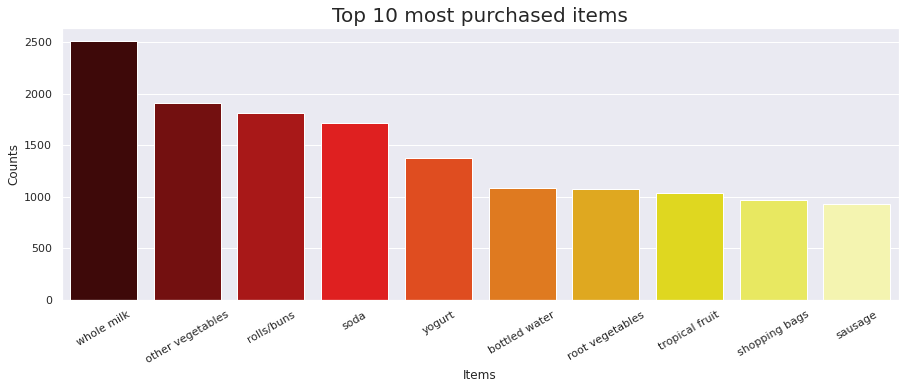

In [182]:
plt.figure(figsize=(15,5))
sns.barplot(x=tdf.sum().nlargest(10).index , y=tdf.sum().nlargest(10).values, palette = 'hot')
plt.xlabel('Items', size = 12)
plt.xticks(rotation=30)
plt.ylabel('Counts', size = 12)
plt.title('Top 10 most purchased items', size = 20)
plt.show()

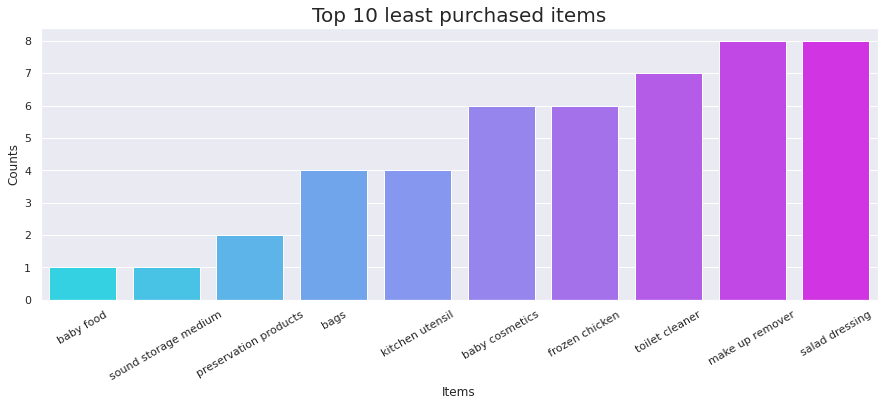

In [183]:
plt.figure(figsize=(15,5))
sns.barplot(x=tdf.sum().nsmallest(10).index , y=tdf.sum().nsmallest(10).values, palette = 'cool')
plt.xlabel('Items', size = 12)
plt.xticks(rotation=30)
plt.ylabel('Counts', size = 12)
plt.title('Top 10 least purchased items', size = 20)
plt.show()

This grocery store makes most of it's revenue from whole milk and vegetables and the least from baby food and sound storage medium.

In [191]:
tdf.sum(1).describe().iloc[1:]

mean     4.409456
std      3.589385
min      1.000000
25%      2.000000
50%      3.000000
75%      6.000000
max     32.000000
dtype: float64

We can see on average a customer puchases 4.4 items where the longest chain is 32 items long, that was a very active shopper. As expected the minimum puchase is 1 since there are no rows with all 0s

### Model building

Apriori is a popular algorithm for extracting frequent itemsets with applications in association rule learning. The apriori algorithm has been designed to operate on databases containing transactions, such as the one we are using.

In [223]:
frequent_itemsets = apriori(tdf, min_support=0.001, use_colnames=True, max_len=2).assign(
        length=lambda x: x['itemsets'].map(lambda x: len(x))
)

In [224]:
frequent_itemsets.head()

,support,itemsets,length
0,0.008033,(Instant food products),1
1,0.033452,(UHT-milk),1
2,0.003559,(abrasive cleaner),1
3,0.003254,(artif. sweetener),1
4,0.017692,(baking powder),1


In [232]:
frequent_itemsets[frequent_itemsets['length'].gt(1) & frequent_itemsets['support'].gt(0.05)]

,support,itemsets,length
2684,0.074835,"(whole milk, other vegetables)",2
2919,0.056634,"(whole milk, rolls/buns)",2
3135,0.056024,"(whole milk, yogurt)",2


An itemset is considered as "frequent" if it meets a user-specified support threshold. For instance, if the support threshold is set to 0.5 (50%), a frequent itemset is defined as a set of items that occur together in at least 50% of all transactions in the database.

association rule mining

In [214]:
rules = association_rules(rule_items, metric="lift", min_threshold=1).sort_values('lift', ascending=False)

In [237]:
rules[rules['lift'].gt(1) & rules['confidence'].gt(0.5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3781,(honey),(whole milk),0.001525,0.255516,0.001118,0.733333,2.870009,0.000729,2.791815
5020,(tidbits),(rolls/buns),0.002339,0.183935,0.001220,0.521739,2.836542,0.000790,1.706318
4538,(rice),(other vegetables),0.007626,0.193493,0.003965,0.520000,2.687441,0.002490,1.680224
1597,(cereals),(whole milk),0.005694,0.255516,0.003660,0.642857,2.515917,0.002206,2.084555
4963,(rice),(whole milk),0.007626,0.255516,0.004677,0.613333,2.400371,0.002729,1.925390
2111,(cocoa drinks),(whole milk),0.002237,0.255516,0.001322,0.590909,2.312611,0.000750,1.819850
4931,(pudding powder),(whole milk),0.002339,0.255516,0.001322,0.565217,2.212062,0.000724,1.712313
3941,(jam),(whole milk),0.005389,0.255516,0.002949,0.547170,2.141431,0.001572,1.644069
223,(baking powder),(whole milk),0.017692,0.255516,0.009253,0.522989,2.046793,0.004732,1.560725
2265,(cooking chocolate),(whole milk),0.002542,0.255516,0.001322,0.520000,2.035097,0.000672,1.551008


support(A→C)=support(A∪C),range: [0,1]

There is a strong association between yogurt and whole milk,

In [217]:
rdf = rules.copy()

Text(0.5, 1.0, 'lift vs confidence')

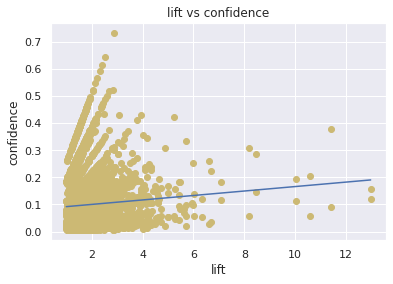

In [222]:
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_funt = np.poly1d(fit)
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
fit_funt(rules['lift']))
plt.xlabel('lift')
plt.ylabel('confidence')
plt.title('{} vs {}'.format('lift', 'confidence'))